In [ ]:
# matplotlib 설정
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np

%matplotlib inline

# mac OS 에서 한글이 깨진다면 참고.
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# NMF

## 1) 데이터 로드 및 확인

유명 정치인 등의 실제 얼굴에 대한 이미지 데이터.  
5749명에 대한 13233개 사진을 가지고 있다.    
이미지에는 다른 조건에서 찍은 사진들이다. (빛이나 얼굴표정 각도등이 다르다.)  

- feature : 각 개인의 얼굴 이미지의 픽셀별 data
- target : 개인을 나타내는 식별 번호


https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

In [ ]:
from sklearn.datasets import fetch_lfw_people

# min_faces_per_person = 20 : 최소 20개 이상의 사진을 가진 인물 데이터만 로드
# resize = 0.4 : 원래 이미지의 0.7의 비율로 크기를 줄여서 로드
data_lfw = fetch_lfw_people(min_faces_per_person=20, resize= 0.7)

print(data_lfw.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

In [ ]:
data_lfw.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [ ]:
# 데이터의 개수를 확인해보자
data_lfw.data.shape

(3023, 5655)

앞서 데이터를 로드할 때 min_faces_per_person 옵션으로 인해 5749개 전체가 아닌 3023개 데이터만 로드한 것을 확인할 수 있다.  
5655은 픽셀의 개수.

In [ ]:
data_lfw.images.shape

(3023, 87, 65)

In [ ]:
# target의 개수와 target의 이름을 확인해보자
print('target의 총 개수 :   {}'.format(data_lfw.target.shape))
print('target 클래스의 개수 :   {}'.format(len(data_lfw.target_names)))
print('target 클래스의 이름 :   {}'.format(data_lfw.target_names))

target의 총 개수 :   (3023,)
target 클래스의 개수 :   62
target 클래스의 이름 :   ['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Huss

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


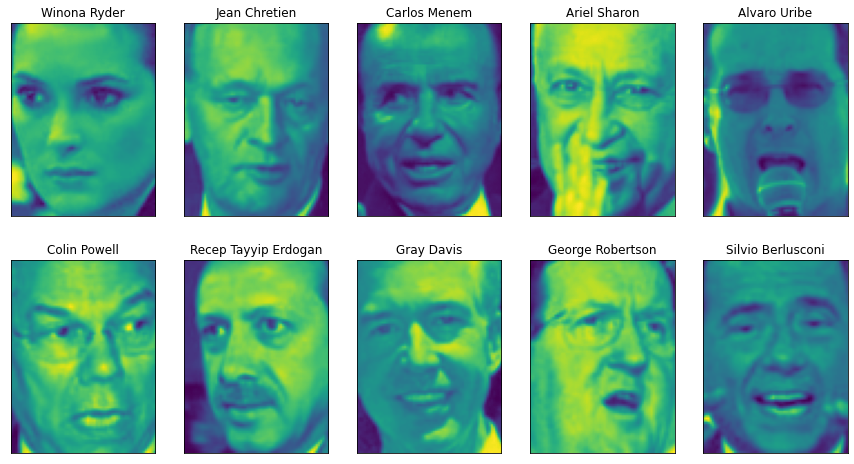

In [ ]:
# 불러온 데이터의 image를 확인해보자

fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks':(), 'yticks':()})

for target, image, ax in zip(data_lfw.target, data_lfw.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(data_lfw.target_names[target])

plt.show()

위와 같이 다양한 유명인물들을 다른 조건에서 촬영한 이미지를 확인할 수 있다.

In [ ]:
print("people.images.shape: {}".format(data_lfw.images.shape))
print("클래스의 개수: {}".format(len(data_lfw.target_names)))

people.images.shape: (3023, 87, 65)
클래스의 개수: 62


하지만 이 데이터셋은 인물에 따른 이미지 수가 편중된 경향이 있으므로 학습을 위해 인물마다 50개의 이미지만 선택하도록 하자.  
만약, 이렇게 하지 않을 경우 많은 이미지를 가진 인물(ex. George W Bush)의 특성이 추출된다.

In [ ]:
mask = np.zeros(data_lfw.target.shape, dtype=np.bool)
for target in np.unique(data_lfw.target):
    mask[np.where(data_lfw.target== target)[0][:50]] = 1

X_data_lfw = data_lfw.data[mask]
y_data_lfw = data_lfw.target[mask]

# 0~255 사이의 흑백 이미지 픽셀 값을 0~1 사이로 스케일 조정하는 코드
X_data_lfw = X_data_lfw / 255.

In [ ]:
# train data와 test data를 분리하자
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data_lfw, y_data_lfw,
                                                   stratify=y_data_lfw,
                                                   random_state=0)

## 2) 모델링

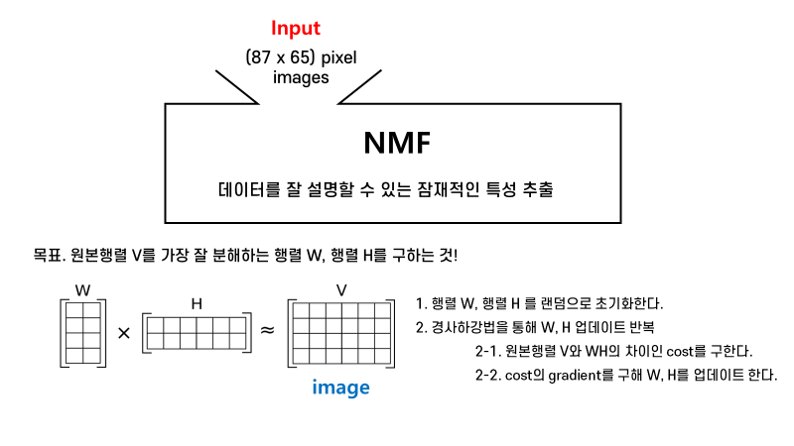

NMF (Non-negative Matrix Factorization)
* 주요 parameter:
 - `n_components` : 추출할 성분의 개수(가장 중요한 파라미터)


참고 : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [ ]:
# NMF를 활용하여 성분을 15개만 추출해보자
from sklearn.decomposition import NMF

model_nmf = NMF(n_components=15, random_state=0)
model_nmf.fit(X_train)
train_nmf = model_nmf.transform(X_train)
test_nmf = model_nmf.transform(X_test)

## 3) 결과 확인

추출된 15개의 성분을 확인해보자

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


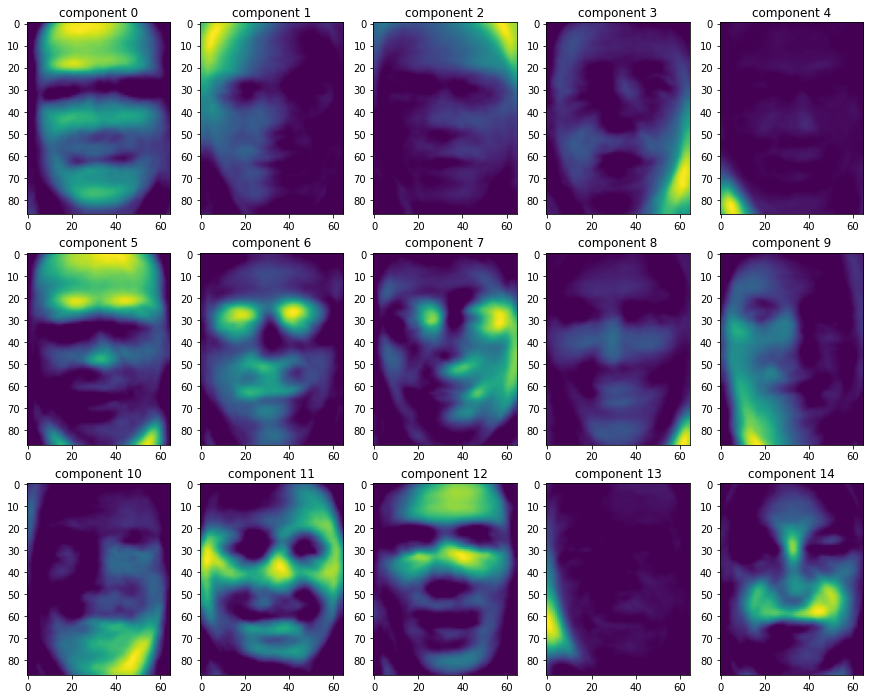

In [ ]:
image_shape = data_lfw.images[0].shape

fig, axes = plt.subplots(3, 5, figsize=(15,12))
for i, (component, ax) in enumerate(zip(model_nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title('component {}'.format(i))

n_component를 15로 설정하여 15개의 성분만 추출해보았다.

그렇다면 NMF을 통해 추출한 성분은 어떤 특징을 나타낼까?

In [ ]:
train_nmf

array([[0.18474299, 0.32086821, 0.55369616, ..., 0.69548976, 0.01726778,
        0.46883846],
       [0.58991314, 0.04708351, 0.        , ..., 0.16323535, 0.1317285 ,
        0.92588411],
       [0.25370649, 0.59945055, 0.38440994, ..., 0.66339596, 0.1412364 ,
        0.40610852],
       ...,
       [0.33904312, 0.40743842, 0.14449532, ..., 0.14557383, 0.12595583,
        0.5803418 ],
       [0.53690306, 0.26281096, 0.38680571, ..., 0.27245282, 0.11392794,
        0.31094203],
       [0.00764662, 0.07413345, 0.04514506, ..., 0.34342342, 0.1969229 ,
        0.70366041]])

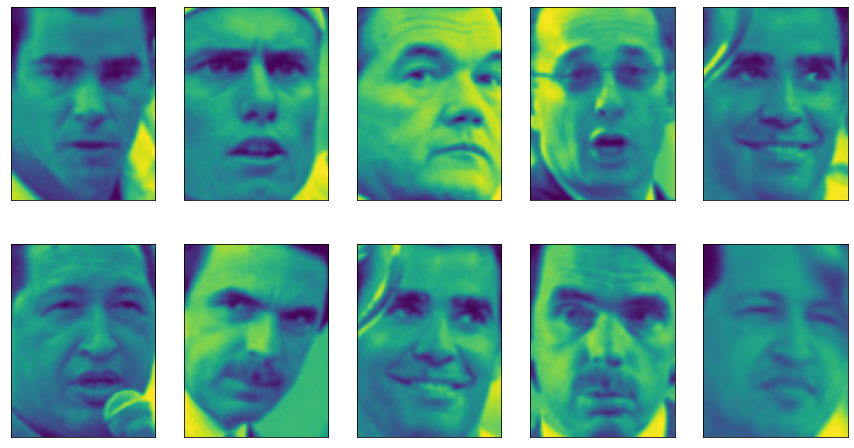

In [ ]:
# 4번째 성분 값이 높은 순서대로 정렬하여 처음 10개 이미지를 출력해보자
compn = 3
inds = np.argsort(train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

4번째 성분은 주로 얼굴이 오른쪽을 향하고 있는 특징을 나타내는 것 같다

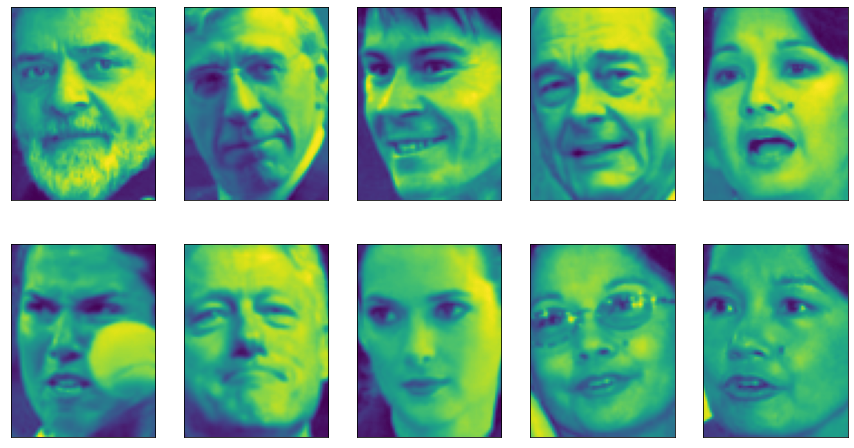

In [ ]:
# 8번째 성분 값이 높은 순서대로으로 정렬하여 처음 10개 이미지를 출력해보자
compn = 7
inds = np.argsort(train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))